In [84]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
!pip install torch
import torch

import h5py
!pip install pyyaml h5py
from IPython.display import clear_output

import math
import random

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#Load h5 data

In [85]:
df = h5py.File("/content/drive/MyDrive/neutrino_data/neutrino1.h5",'r')

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
images = []

print(np.shape(df['cvnmap']))
n = 0
for i in range(0,math.floor(len(df['cvnmap']))):
  event0=np.array(df['cvnmap'][i]).reshape((2,100,80))
  n+=1
  clear_output()
  print(str(100*round(n/math.floor(len(df['cvnmap'])),2)) + "%")
  images.append(event0[1].T)

images = np.array(images)
print(images.shape)

100.0%
(7001, 80, 100)


In [86]:
train_images_unprocessed = np.array(images[:-math.floor(len(images)*0.2)])           #torch.tensor(np.array())
test_images_unprocessed  = np.array(images[len(images) - math.floor(len(images)*0.2):])

print(train_images_unprocessed.shape)
print(test_images_unprocessed.shape)

(5601, 80, 100)
(1400, 80, 100)


#Load personal dataset

In [ ]:
def convertImagesToArray(imageptrs):
  images = []

  n = 0
  for pImage in imageptrs:
    #print(plt.imread(pImage[:-1]))
    images.append(plt.imread(pImage[:-1]))
    n+=1
    clear_output()
    print(str(100 * round(n/len(imageptrs),2)) + "%")

  return images

In [ ]:
file = open("/content/drive/MyDrive/Testing_VAE/pointerlists/stringlist.txt", 'r')

imageptrs = []
#print(len(file.readlines()))
for line in file.readlines():
  imageptrs.append(line)

train_images_fresh_images = convertImagesToArray(imageptrs[:-round(len(imageptrs)*0.2)])
test_images_fresh_images  = convertImagesToArray(imageptrs[-round(len(imageptrs)*0.2):-1])

train_images_unprocessed = train_images_fresh_images
test_images_unprocessed  = test_images_fresh_images

print(np.array(train_images_unprocessed).shape)
print(np.array(test_images_unprocessed).shape)


100.0%
(1136, 128, 128, 3)
(283, 128, 128, 3)


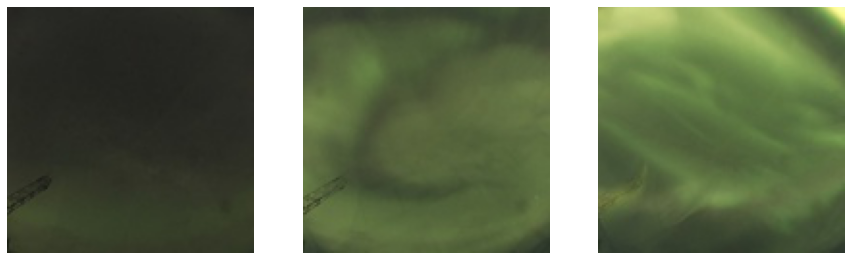

In [ ]:
#Display example images from dataset
f = plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(train_images_unprocessed[random.randint(0,len(train_images_unprocessed)-1)])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train_images_unprocessed[random.randint(0,len(train_images_unprocessed)-1)])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train_images_unprocessed[random.randint(0,len(train_images_unprocessed)-1)])
plt.axis('off')
plt.show()

#Preprocessing functions

Define preprocessing procedure

In [87]:
def preprocess_images(copy_imagelist):
  imagelist = []
  imagelist = copy_imagelist
  for i in range(len(imagelist)):
    imagelist[i] = imagelist[i] / 255.#np.max(imagelist[i])
  imagelist = torch.tensor(np.array(imagelist))

  imagelist = imagelist.reshape((imagelist.shape[0], imagelist.shape[1], imagelist.shape[2], 3))
  #imagelist.reshape((imagelist.shape[0], imagelist.shape[1], imagelist.shape[2], 1))
  return tf.cast(imagelist, tf.float32) #np.where(imagelist > .5, 1.0, 0.0).astype('float32')

def preprocess_images_reduce_neutrino(imagelist):
  #print(imagelist.shape)
  imagelist_processed = []
  for i in range(len(imagelist)):
    img = imagelist[i]
    cropped_img = 255.*img[:,:80]#/np.amax(img)
    imagelist_processed.append(cropped_img)
  imagelist_processed = np.array(imagelist_processed)
  #print(imagelist_processed.shape)
  imagelist_processed = torch.tensor(imagelist_processed)
  imagelist_processed = imagelist_processed.reshape((imagelist_processed.shape[0], imagelist_processed.shape[1], imagelist_processed.shape[2], 1))
  return tf.cast(imagelist_processed, tf.float32)
    

#Preprocess using normalization of image brightness

In [33]:
train_images = preprocess_images(train_images_unprocessed)
test_images  = preprocess_images( test_images_unprocessed)

print(train_images.shape)
print(test_images.shape)

RuntimeError: ignored

In [ ]:
#Display example images from dataset
f = plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
ind1 =  random.randint(0,len(train_images)-1)
plt.imshow(train_images_unprocessed[ind1])
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(train_images[ind1])
plt.axis('off')
plt.subplot(2,3,2)
ind2 =  random.randint(0,len(train_images)-1)
plt.imshow(train_images_unprocessed[ind2])
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(train_images[ind2])
plt.axis('off')
plt.subplot(2,3,3)
ind3 =  random.randint(0,len(train_images)-1)
plt.imshow(train_images_unprocessed[ind3])
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(train_images[ind3])
plt.axis('off')
plt.show()

print(np.max(train_images_unprocessed[ind1]))
print(np.max(train_images[ind1])*255)

#Preprocess NEUTRINO images to be square and normalized

In [88]:
train_images = preprocess_images_reduce_neutrino(train_images_unprocessed)
test_images  = preprocess_images_reduce_neutrino( test_images_unprocessed)

print(train_images.shape)
print(test_images.shape)

(5601, 80, 80, 1)
(1400, 80, 80, 1)


#Training/Testing Variables

In [89]:
train_size = len(train_images)
batch_size = 32
test_size  = len(test_images) 

#Batch/Dataset construction

In [90]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

#Network Architectures

##CVAE Network (Encoder + Decoder) for AURORA data (Custom)

In [91]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
            tf.keras.layers.Conv2DTranspose(
                filters=4, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2D(
                filters=4, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
         
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*batch_size, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4,4,batch_size)),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=8, kernel_size=3, strides=(2,2), padding='same',
                activation='relu'),

            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=(2,2), padding='same')
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(batch_size, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, inputs):
    a,b = self.encode(inputs)
    #print("encoded...")
    x = self.reparameterize(a,b)
    #print("reparameterized...")
    x = self.sample(x)
    #print("sampled...")
    return x

##CVAE Network (Encoder + Decoder) for AURORA data (*Deep Feature Consistent Variational Autoencoder*)

In [92]:
class CVAE_DFCVA(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE_DFCVA, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
         
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=128, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=256, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Flatten(),
         
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*batch_size, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4,4,batch_size)),

            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
         
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),

         
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),


            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            
            # No activation
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=3, kernel_size=3, strides=(1,1), padding='same')
         
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(batch_size, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, inputs):
    a,b = self.encode(inputs)
    #print("encoded...")
    x = self.reparameterize(a,b)
    #print("reparameterized...")
    x = self.sample(x)
    #print("sampled...")
    return x

##CVAE for neutrino data

In [93]:
class CVAENeutrino(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAENeutrino, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(80, 80, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=8,  kernel_size=3, strides=2, padding='same',
                activation='relu'),
         
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(80*80*1),
            tf.keras.layers.Reshape(target_shape=(80,80,1))
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, inputs):
    a,b = self.encode(inputs)
    #print("encoded...")
    x = self.reparameterize(a,b)
    #print("reparameterized...")
    x = self.sample(x)
    #print("sampled...")
    return x

##CVAE Network (Encoder + Decoder) for NEUTRINO data (*Deep Feature Consistent Variational Autoencoder*)

In [117]:
class CVAE_DFCVA_NEUTRINO(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE_DFCVA_NEUTRINO, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(80, 80, 1)),
         
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=128, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(
                filters=256, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Flatten(),
         
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=5*5*batch_size, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(5,5,batch_size)),

            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
         
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),

         
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),


            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(1,1), padding='same',
                activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            
            # No activation
            #tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(
                filters=1, kernel_size=3, strides=(1,1), padding='same')
         
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(batch_size, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, inputs):
    a,b = self.encode(inputs)
    #print("encoded...")
    x = self.reparameterize(a,b)
    #print("reparameterized...")
    x = self.sample(x)
    #print("sampled...")
    return x

##Test model is working

In [95]:
#model = CVAE(30)
#model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
#            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#            metrics=[tf.metrics.SparseCategoricalAccuracy()])
#model.call(test_images)
#model.build((1,128,128,3))
#model.summary()
#model.save_weights("/content/drive/MyDrive/Testing_VAE/model_checkpoints/weightsTest")
#
#model.load_weights("/content/drive/MyDrive/Testing_VAE/model_checkpoints/weightsTest")

#Training step methods

In [118]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#Setup for training and model instantiation (including loss function)

In [119]:
epochs = 1000
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE_DFCVA_NEUTRINO(latent_dim)

#Build / compile the model and show a summary
model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.call(test_images)
model.build((1,80,80,1))
model.summary()

Model: "cvae_dfcva_neutrino_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 4)                 716644    
                                                                 
 sequential_29 (Sequential)  (None, 80, 80, 1)         137313    
                                                                 
Total params: 853,957
Trainable params: 852,549
Non-trainable params: 1,408
_________________________________________________________________


#Load previous model weights

In [ ]:
model.load_weights("/content/drive/MyDrive/Testing_VAE/model_checkpoints/DFCVAmodel-29_1_22-e2000-aurora-latentdims10")

#Taking a sample and epoch, make and show the images the model predicted

In [120]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  predictions = np.array(predictions)

  fig1 = plt.figure(figsize=(15, 8))
  for i in range(0,predictions.shape[0]):
    plt.subplot(4, 8, (2*i+1))
    plt.imshow(test_sample[i,:,:,0],cmap='plasma')
    plt.axis('off')
   
    plt.subplot(4, 8, 2*i+2)
    plt.imshow(predictions[i,:,:,0],cmap='plasma')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#Pick a sample of the test set for generating output images

In [121]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :]

#Train Network

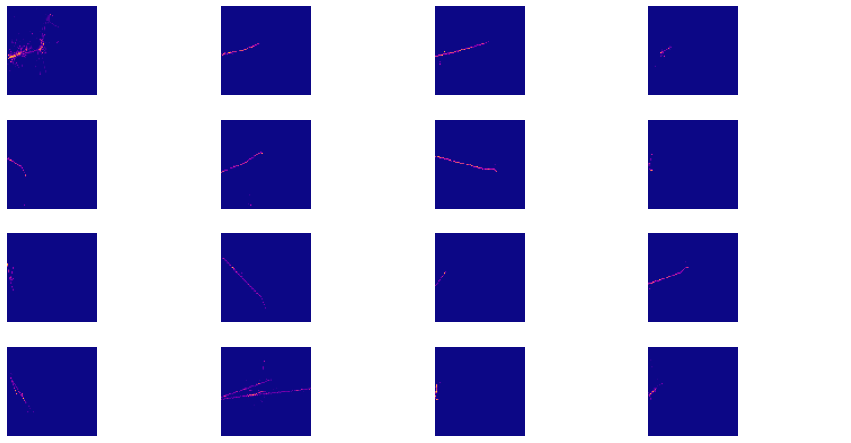

KeyboardInterrupt: ignored

In [122]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1,epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  if epoch%5 == 0:
    display.clear_output(wait=False)
    generate_and_save_images(model, epoch, test_sample)

#Saving the model

In [ ]:
model_name = "DFCVAmodel-29_1_22-e3000-aurora-latentdims10"
model.save_weights("/content/drive/MyDrive/Testing_VAE/model_checkpoints/"+model_name)

In [ ]:
anim_file = '/content/drive/MyDrive/Testing_VAE/model_checkpoints/DFCVAmodel-29_1_22-e3000-aurora-latentdims10_ANIMATED.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  n = 0
  for filename in filenames:
    if n%1==0:
      image = imageio.imread(filename)
      writer.append_data(image)
    n = n + 1
  image = imageio.imread(filename)
  writer.append_data(image)

#Explore the latent space

[ 1.8519489  -1.4619637  -0.4534194  -0.7507452  -1.2104216  -0.74983126
 -2.5928638   0.9145244   0.07817315 -0.8081881  -0.3421285   1.319521
 -0.44982377  0.26849893  0.6906587  -1.6624908  -0.6621567   0.900406
  1.6305248  -1.5013416   0.221276   -0.5203113  -0.52717805  0.59453076
 -0.05092072]


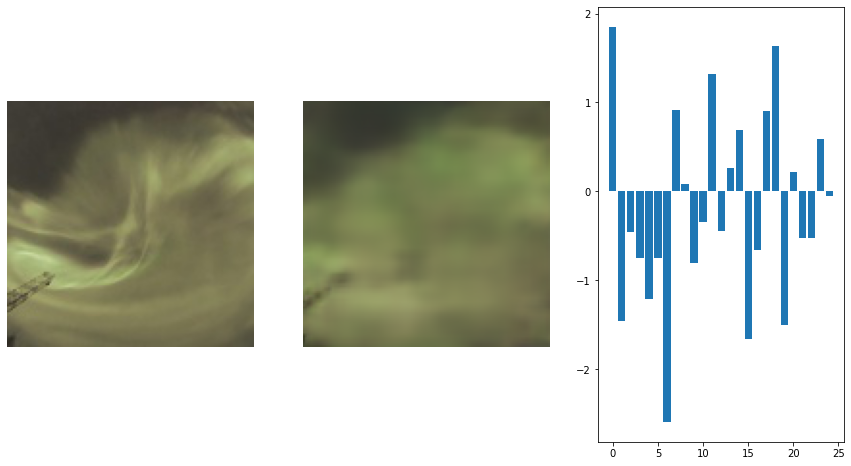

ValueError: ignored

In [ ]:

mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)
predictions = np.array(predictions)

fig = plt.figure(figsize=(15, 8))
#for i in range(0,predictions.shape[0]):
plt.subplot(1, 3, 1)
plt.imshow(test_sample[6,:,:,:])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predictions[6,:,:,:])
plt.axis('off')

print(z.numpy()[6])
latent_variables = z.numpy()[6]
plt.subplot(1, 3, 3)
plt.bar(range(latent_dim), latent_variables)

plt.show()


def create_image(l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14,l15,l16,l17,l18,l19,l20,l21,l22,l23,l24,l25):
  latent_values = torch.tensor(np.array([l1,l2,l3,l4,l5,
                                                 l6,l7,l8,l9,l10,
                                                 l11,l12,l13,l14,l15,
                                                 l16,l17,l18,l19,l20,
                                                 l21,l22,l23,l24,l25]))
  latent_values = tf.cast(latent_values.reshape((1,latent_values.shape[0])),tf.float32)

  predictions = model.sample(latent_values)
  predictions = np.array(predictions)

  plt.imshow(predictions[0,:,:,:])

interactive_latent_plot = interactive(create_image, l1=(-2.0,2.0),l2=(-2.0,2.0),l3=(-2.0,2.0),l4=(-2.0,2.0),l5=(-2.0,2.0),
                                                    l6=(-2.0,2.0),l7=(-2.0,2.0),l8=(-2.0,2.0),l9=(-2.0,2.0),l10=(-2.0,2.0),
                                                    l11=(-2.0,2.0),l12=(-2.0,2.0),l13=(-2.0,2.0),l14=(-2.0,2.0),l15=(-2.0,2.0),
                                                    l16=(-2.0,2.0),l17=(-2.0,2.0),l18=(-2.0,2.0),l19=(-2.0,2.0),l20=(-2.0,2.0),
                                                    l21=(-2.0,2.0),l22=(-2.0,2.0),l23=(-2.0,2.0),l24=(-2.0,2.0),l25=(-2.0,2.0))
interactive_latent_plot


#Generate large plot for many latent arrangements

In [ ]:
def create_image(lvs):
  latent_values = torch.tensor(np.array(lvs))
  latent_values = tf.cast(latent_values.reshape((1,latent_values.shape[0])),tf.float32)

  predictions = model.sample(latent_values)
  predictions = np.array(predictions)

  plt.imshow(predictions[0,:,:,:])
  return predictions[0,:,:,:]

Iteration 0/100...


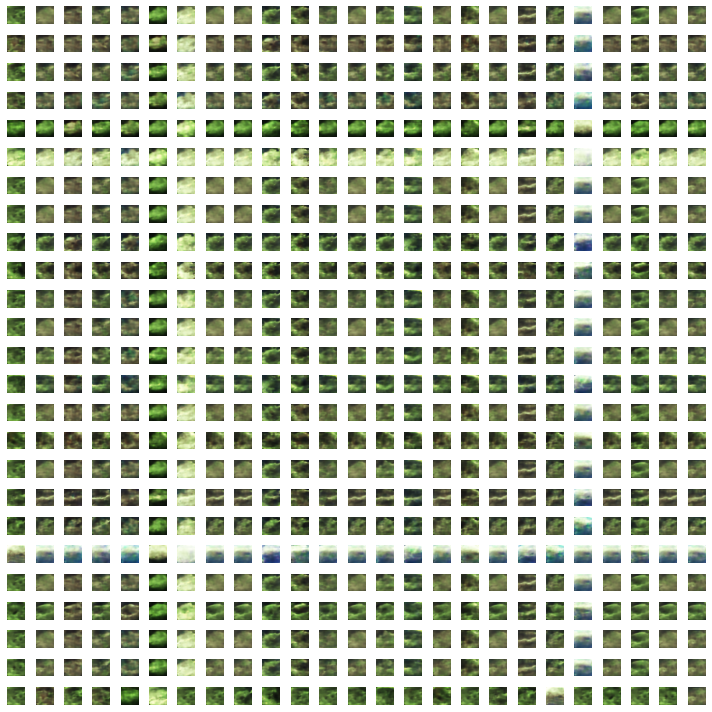

Iteration 1/100...


KeyboardInterrupt: ignored

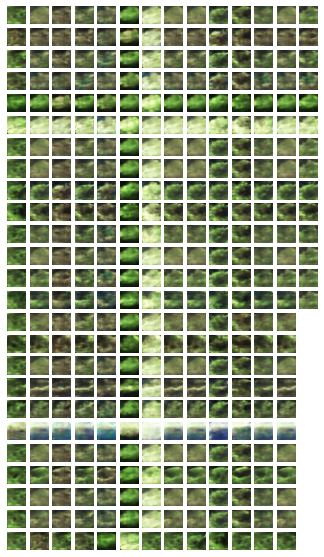

In [ ]:
#A particularly interesting image, lets start from that and move in latent space
dlvs = [2.1231427,  -0.43697354, -0.43702,    -0.81122315, -1.189062,
      -0.7977576, -2.613166,    0.2511292,   0.5142902,  -0.6348763,
      -0.44030625,  1.2702676, 0.8265532,   0.16151245,  0.5486621,
      -1.322041,   -0.9327319,  -0.11249822, 1.4143479,  -1.2551053,   
      0.19107173, -1.215338,   -0.53439295, -0.58033717, 0.19831619]

steps = 100

grid_of_images = []
for i in range(latent_dim):
  grid_of_images.append([])
  for j in range(latent_dim):
    grid_of_images[i].append([])

for iter in range(0,steps+1):
  print("Iteration {}/{}...".format(iter,steps))
  fig = plt.figure(figsize=(10,10))
  dyn_lv = 10.0*(-1 + (iter/steps)*2)
  for i in range(latent_dim):
    for j in range(latent_dim):
      t_dlvs = []
      t_dlvs[:] = dlvs[:]
      t_dlvs[i] = dyn_lv
      t_dlvs[j] = dyn_lv
      grid_of_images[i][j] = create_image(t_dlvs) 
      plt.subplot(latent_dim,latent_dim,(i%latent_dim+1)+j*latent_dim)
      plt.imshow(grid_of_images[i][j])
      plt.axis('off')
      plt.axis('tight')
      #print("i:", i)#, "    ", "j:", j)
      #print(t_dlvs)
  fig.tight_layout()
  plt.savefig("/content/drive/MyDrive/Testing_VAE/Latent_Space_Analysis/Experiment3/latent_space_at_step_{:04d}.png".format(iter))
  plt.show()
  

In [ ]:
anim_file = '/content/drive/MyDrive/Testing_VAE/Latent_Space_Analysis/Experiment3/latent_space.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/Testing_VAE/Latent_Space_Analysis/Experiment3/latent_space*.png')
  filenames = sorted(filenames)
  n = 0
  for filename in filenames:
    if n%1==0:
      image = imageio.imread(filename)
      writer.append_data(image)
    n = n + 1
  image = imageio.imread(filename)
  writer.append_data(image)